# Final Project (Parts III and IV)
## Adam Lowet

### (Re-import and re-define utility functions, adding some extra functionality for Markov Models)

In [1]:
import numpy as np
from math import ceil
import nibabel as nib
import os
import time
import random
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from sklearn import metrics
from sklearn.cluster import AffinityPropagation, KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from nilearn import plotting
import scipy.stats
from brainiak.fcma.preprocessing import RandomType
from brainiak.fcma.util import compute_correlation
from brainiak import io
from itertools import cycle

mpl.rcParams['image.interpolation'] = 'none'
mpl.rcParams['image.resample'] = False

In [2]:
# define some utility functions
def compute_correlation_matrices(in_array, n, take_every=1, plot=False, plot_label='Voxel'):
    
    if plot:
        fig, axs = plt.subplots(2,n//2, figsize=(15, 15))
        fig.subplots_adjust(hspace = .1, wspace=.001)
        axs = axs.ravel()
    
    n_voxels = ceil(in_array[0].shape[1]/take_every)
    out_array = np.zeros((n_voxels, n_voxels, n))
    for i in range(n):

        #extract data for one subject, for one epoch
        data=in_array[i][:,::take_every].T
        #print(data.shape)

        # Make the data c contiguous (the type of ordering used in C in which the last dimensions are stored first (opposite of fortran/matlab))
        mat = np.ascontiguousarray(data, dtype=np.float32)

        # Voxels X TRs for one epoch
        begin_time = time.time()
        epoch_corr=compute_correlation(mat, mat)
        end_time = time.time()
        #print("Analysis duration: %0.5fs" % (end_time - begin_time))
        
        out_array[:,:,i] = epoch_corr
        
        if plot:
            # Remove the diagonal for visualization (guaranteed to be 1.0)
            np.fill_diagonal(epoch_corr, np.nan)
            im = axs[i].imshow(epoch_corr)
            axs[i].set_title('Correlations for Subject ' + str(ppt+i))
            axs[i].set_xlabel(plot_label)
            axs[i].set_ylabel(plot_label)
    
    if plot:
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
        fig.colorbar(im, cax=cbar_ax)
        plt.show()
        
    return out_array

def compute_sliding_correlation_matrices(in_array, TR_window, step, n_TR, take_every):

    n_steps = 1 + (n_TR-TR_window)//step #(n_TR+1-TR_window)//step
    n_voxels = ceil(in_array[0].shape[1]/take_every)
    out_array = np.zeros((n_steps*n_subj, ((n_voxels**2-n_voxels)//2)))

    for i in range(n_subj):
        
        #extract data for one subject, for one epoch (take only the every "take_every"th voxel)
        sub_data=in_array[i][:,::take_every].T
        print(sub_data.shape)
        
        for j in range(n_steps):

            window_data = sub_data[:,j*step:(j*step)+TR_window]

            # Make the data c contiguous (the type of ordering used in C in which the last dimensions are stored first (opposite of fortran/matlab))
            mat = np.ascontiguousarray(window_data, dtype=np.float32)

            # Voxels X TRs for one epoch
            epoch_corr=compute_correlation(mat, mat)        
            epoch_corr_vector = epoch_corr[np.triu_indices(epoch_corr.shape[0], k=1)]

            #store vectors as row in array
            out_array[j+(n_steps*i),:] = epoch_corr_vector
    
    return out_array

In [3]:
def affinity_prop(concatenated_data, plot=True, title_string=''):
    
    # Compute Affinity Propagation
    af = AffinityPropagation(max_iter=10000).fit(concatenated_data)
    cluster_centers_indices = af.cluster_centers_indices_
    labels = af.labels_

    n_clusters = len(cluster_centers_indices)
    sil_score = metrics.silhouette_score(concatenated_data, labels, metric='sqeuclidean')

    print('Estimated number of clusters: %d' % n_clusters)
    print("Silhouette Coefficient: %0.3f" % sil_score)

    # #############################################################################
    # Plot result
    
    if plot:
        plt.figure()
        plt.clf()

        colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
        for k, col in zip(range(n_clusters), colors):
            class_members = labels == k
            cluster_center = concatenated_data[cluster_centers_indices[k]]
            plt.plot(concatenated_data[class_members, 0], concatenated_data[class_members, 1], col + '.')
            plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
                     markeredgecolor='k', markersize=14)
            for x in concatenated_data[class_members]:
                plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

        plt.title('Estimated number of clusters: %d' % n_clusters)
        plt.show()
        
        plt.figure()
        plt.plot(labels)
        n_TR_subj = concatenated_data.shape[0]//n_subj
        for i in range(1, n_subj+1):
            plt.axvline(x=i*n_TR_subj, ls='--', c='g')
        plt.xlabel('TR')
        plt.ylabel('Cluster')
        plt.title('Affinity Propagation Clusters over ' + title_string + ' Data')
    
    return {'prototypes':cluster_centers_indices,
            'labels': labels,
            'n_clusters': n_clusters,
            'score': sil_score}

def k_mean(in_array, n, plot=True, title_string=''):
    
    kmean = KMeans(n_clusters=n)
    kmean_results = kmean.fit(in_array)
    kmean_labels = kmean_results.labels_
    
    if plot:
        plt.figure()
        plt.plot(kmean_labels)
        n_TR_subj = in_array.shape[0]//n_subj
        for i in range(1, n_subj+1):
            plt.axvline(x=i*n_TR_subj, ls='--', c='g')
        plt.xlabel('TR')
        plt.ylabel('Cluster')
        plt.title('k-Means Clusters over ' + title_string + ' Data')
    
    return kmean_labels

In [4]:
def z_score(in_array, high_pass=None, across_time=True, across_space=False):
    
    z_scored = in_array
    print(z_scored.shape)
    
    #do high-pass filtering on each time series of voxels
    if high_pass is not None:
        
        def butter_highpass(cutoff, fs, order=5):
            nyq = 0.5 * fs
            normal_cutoff = cutoff / nyq
            b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
            return b, a

        def butter_highpass_filter(data, cutoff=1/high_pass, fs=1/TR_duration, order=5):
            b, a = butter_highpass(cutoff, fs, order=order)
            y = signal.filtfilt(b, a, data)
            return y
    
        z_scored = np.apply_along_axis(butter_highpass_filter, axis=0, arr=z_scored)
    
    #z-score across time
    if across_time:
        #z-score each voxel across time
        scaler = preprocessing.StandardScaler().fit(z_scored)
        z_scored =  scaler.transform(z_scored)
    
    #z-score across space (part of trying to get clustering to work)
    if across_space:
        z_scored = z_scored.T
        scaler = preprocessing.StandardScaler().fit(z_scored)
        z_scored =  scaler.transform(z_scored)
        z_scored = z_scored.T
    
    return z_scored

In [5]:
#https://stackoverflow.com/questions/46657221/generating-markov-transition-matrix-in-python
def transition_matrix(transitions, n):

    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M

def calculate_transition_matrices(in_labels, plot=True, title_string=''):
    n_TR_subj = len(in_labels)//n_subj
    n_states = np.amax(in_labels) + 1
    all_mats = np.zeros((n_states, n_states, n_subj))
    for i in range(n_subj):
        t = in_labels[i*n_TR_subj:(i+1)*n_TR_subj]
        m = transition_matrix(t, n_states)
        all_mats[:,:,i] = m
    
    if plot:
        fig, axs = plt.subplots(n_subj//2, 2, figsize=(10, 10))
        fig.subplots_adjust(hspace = .4, wspace=.001)
        axs = axs.ravel()

        for i in range(n_subj):
            im = axs[i].imshow(all_mats[:,:,i])
            axs[i].set_title('TPM for Subject ' + str(ppt+i))
       
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
        fig.colorbar(im, cax=cbar_ax)
        plt.suptitle('Transition Probability Matrices from ' + title_string)
        plt.show()

    return all_mats

In [6]:
def compute_asymmetry(tpm):
    upper_diag = tpm[np.triu_indices(tpm.shape[0], k=1)]
    lower_diag = tpm[np.tril_indices(tpm.shape[0], k=-1)]
    score = np.abs(np.sum(upper_diag - lower_diag))
    return score

def compute_stability(tpm):
    return np.sum(np.diagonal(tpm))

def plot_hists(shuff, actual, title_string=''):
    fig, axs = plt.subplots(n_subj//2, 2, sharey=True, sharex=True, tight_layout=True)
    axs = axs.ravel()

    for i in range(n_subj):
        p = np.sum(shuff[i] > actual[i])/shuff[i].size
        axs[i].hist(shuff[i], bins=20, color='c')
        axs[i].axvline(actual[i], color='k', linestyle='dashed', linewidth=2)
        axs[i].set_title('Subject ' + str(i+ppt) + ': p=' + str(p))

    plt.suptitle(title_string)
    plt.show()

# Voxelwise analyses
## 5. Load in the data voxelwise

To facilitate inter-subject comparison, I take all brains (already in MNI-152 space) and compute the intersection mask among them.

In [7]:
dir = '/gpfs/milgram/scratch/cmhn-s18/asl65/cmhn-s18-wk12-final-adamlowet/'

ppt = 105
n_subj = 8
n_TR = 132
TR_duration = 2.5
random.seed(1)

# Load participants
sub_array = [] #array to hold all subjects' data
for sub in range(ppt, ppt+n_subj):
    
    #use preprocessed data with motion correction
    epi_in = (dir + 'wash120/sub-%03d/func/sub-%03d-new.feat/stats/res4d.nii.gz' % (sub, sub))
    epi_data = nib.load(epi_in)
    print(('Loaded data for subject %03d' % (sub)))
    
    #compute mask by removing entries that are always zero for any subject
    if sub == ppt:
        mask = (np.mean(abs(epi_data.get_data()),3) > 0).astype(int)
    else:
        mask *= (np.mean(abs(epi_data.get_data()),3) > 0).astype(int) # Get the intersection mask (so that the voxels are the same across subjects)   

mask_image = nib.Nifti1Image(mask, np.eye(4))
nifti_masker = NiftiMasker(mask_img=mask_image)
for sub in range(ppt, ppt+n_subj):
    
    epi_in = (dir + 'wash120/sub-%03d/func/sub-%03d-new.feat/stats/res4d.nii.gz' % (sub, sub))
    epi_data = nib.load(epi_in)
    epi_mask_data = nifti_masker.fit_transform(epi_data)
    #epi_mask_data = np.transpose(epi_mask_data)

    preprocessed_data = z_score(epi_mask_data, high_pass=None, across_time=True, across_space=False)
    
    #keep subjects separate for subject-wise analyses
    sub_array.append(preprocessed_data)
    
    #print(preprocessed_data.shape)
    #print(np.mean(preprocessed_data[:,0])) #should be zero
    
    #concatenate the data for group analyzes
    if sub == ppt:
        concatenated_data = preprocessed_data
    else:
        concatenated_data = np.vstack((concatenated_data, preprocessed_data))

Loaded data for subject 105
Loaded data for subject 106
Loaded data for subject 107
Loaded data for subject 108
Loaded data for subject 109
Loaded data for subject 110
Loaded data for subject 111
Loaded data for subject 112
(132, 20232)
(132, 20232)
(132, 20232)
(132, 20232)
(132, 20232)
(132, 20232)
(132, 20232)
(132, 20232)


## 6. Perform FCMA and Cluster
### *Note to grader:* This is a combination of two techniques we talked about in class that don't naturally go together (Bonus 1)

The functional connectome computed over Shen et al., 2013 anatomical parcellation revealed very little consistency between subjects. Is this an intrinsic fact about how the brain is organized, or is it simply an artifact of averaging across hundreds or even thousands of voxels? To find out, here I perform Full Correlation Matrix Analysis over a large number of voxels. As before, to get data for clustering, I compute a sliding window correlation over the voxel time courses, vectorize, concatenate, and then cluster across subjects.

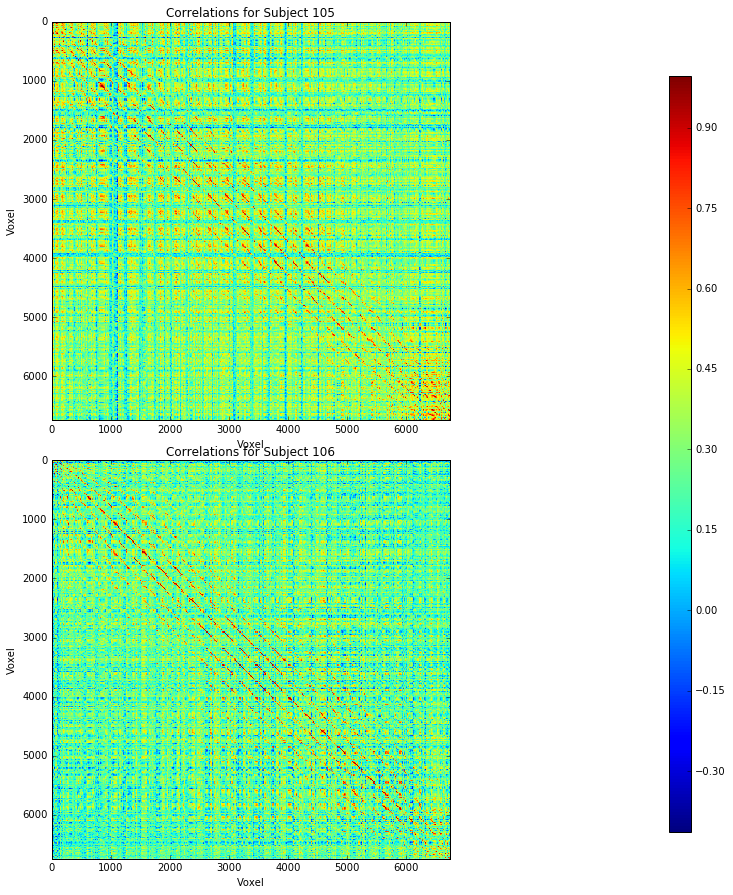

In [8]:
corr_array = compute_correlation_matrices(sub_array, n=2, take_every=3, plot=True, plot_label='Voxel')

In [9]:
#sliding window correlations for clustering
rolling_corr_array = compute_sliding_correlation_matrices(sub_array, TR_window=10, step=5, n_TR=132, take_every=5)
print(rolling_corr_array.shape)

(4047, 132)
(4047, 132)
(4047, 132)
(4047, 132)
(4047, 132)
(4047, 132)
(4047, 132)
(4047, 132)
(200, 8187081)


Estimated number of clusters: 64
Silhouette Coefficient: 0.211


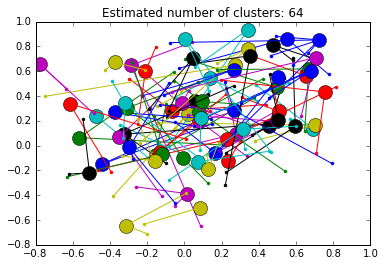

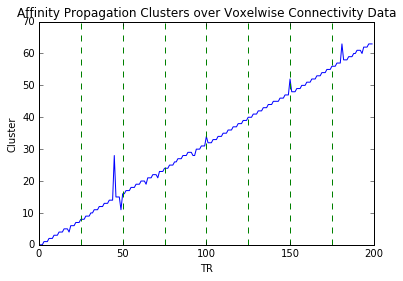

In [10]:
rolling_corr_clusters = affinity_prop(rolling_corr_array, title_string='Voxelwise Connectivity')

## 7. Visualize the BOLD data in PCA space

Evidently the voxelwise correlations are no much better at finding similarities between subjects. Therefore I will go back to the original BOLD data and see if it can find such similarities. As a first pass at getting a handle on these data, I will project them along their first three principal components and then plot these projections in PCA space. This can be done on each subject's data individually, or on the concatenated data.

In [13]:
# We now use the PCA function in scikit-learn to reduce the dimensionality of the data
pca = PCA(n_components=3)
pca_array = []
for i in range(n_subj):
    pca_data = sub_array[i]
    bold_pca = pca.fit_transform(pca_data)
    pca_array.append(bold_pca)

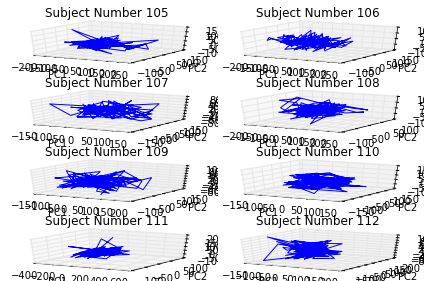

In [14]:
#plot the data in PCA space
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
for i in range(n_subj):
    ax = fig.add_subplot(n_subj//2, 2, i+1, projection='3d')
    ax.set_title('Subject Number ' + str(ppt+i))
    ax.plot(pca_array[i][:,0], pca_array[i][:,1], pca_array[i][:,2])
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
#fig.subplots_adjust(hspace=.5)
fig.tight_layout()
plt.show()

In [15]:
pca = PCA(n_components=3)
pca_all = pca.fit_transform(concatenated_data)
print(pca.explained_variance_ratio_)
print(pca_all.shape)

[ 0.18283917  0.04450304  0.03554129]
(1056, 3)


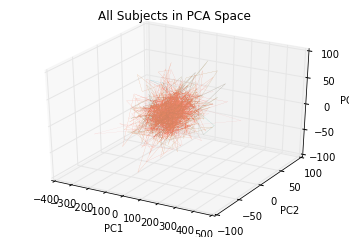

In [16]:
fig = plt.figure()
ax = fig.gca(projection='3d')
color=iter(plt.cm.rainbow(np.linspace(0,1,n_subj)))
for i in range(0, n_subj):
    c=next(color)
    ax.plot(pca_all[i:i*n_TR,0], pca_all[i:i*n_TR,1], pca_all[i:i*n_TR,2], c=c, alpha=0.3,lw=0.1)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('All Subjects in PCA Space')
plt.show()

## 8. Cluster BOLD Activity

Clearly, the raw BOLD data are pretty messy, with no clear patterns emerging in PCA space. However, the data are all highly overlapping in the above plot, so it is possible that subjects are cycling through the same set of BOLD activity states. I now perform clustering to test this hypothesis.

(1056, 20232)
Estimated number of clusters: 66
Silhouette Coefficient: 0.004


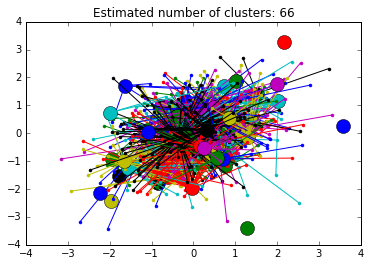

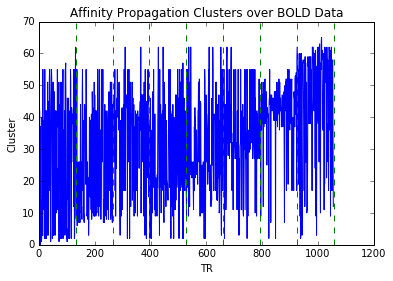

In [17]:
#concatenated_data = concatenated_data.T
print(concatenated_data.shape)
raw_clusters = affinity_prop(concatenated_data, title_string='BOLD')

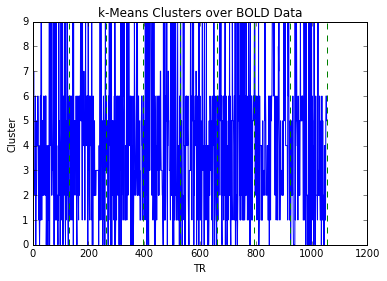

In [18]:
raw_k_labels = k_mean(concatenated_data, 10, title_string='BOLD')

# IV. Markov Modeling
## 9. Calculate Transition Probability Matrices
### *Note to grader:* This is a "novel technique" that we did not talk about in class (Bonus 2)

Voila! We finally see that in terms of raw BOLD activity, there are many states that cluster across subjects, even when using affinity propagation and not specifying the number of clusters _a priori_. Because of this overlap, we can now empirically estimate a Transition Probability Matrix (TPM) for each subject on the basis of the cluster time series that we just estimated. Below, I do so separately for clusters defined by affinity propagation and k-means clustering.

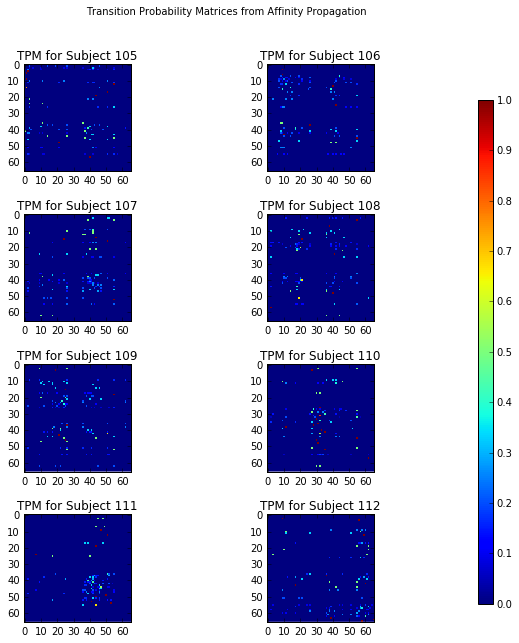

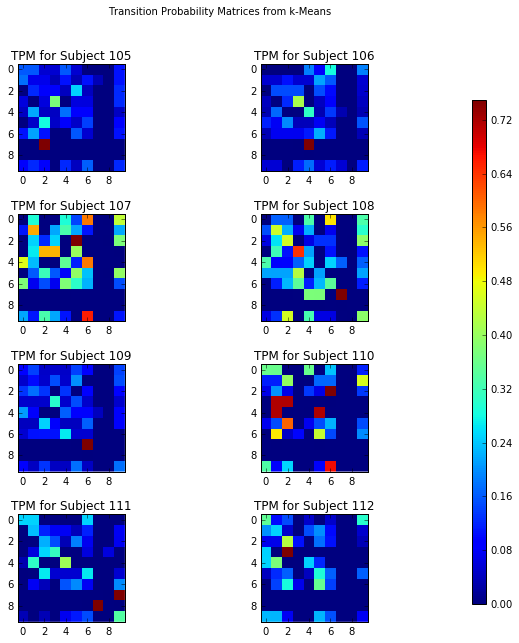

In [19]:
raw_af_trans = calculate_transition_matrices(raw_clusters['labels'], title_string = "Affinity Propagation")
raw_k_trans = calculate_transition_matrices(raw_k_labels, title_string = "k-Means")

## 10. Compute statistics over TPMs

There are several interesting quantities we can calculate over these TPMs. One is the asymmetry: the absolute value of the probability of transitioning from state 1 -> 2 minus the probability of transitioning from state 2 -> 1, computed over all state pairs and summed. Another is the stability: the sum of the major diagonal of the matrix, which is the probability of staying in the same state, summed over all states.

Apart from these statistics, there are also several possible null distributions with which we can compare our empicially estimated TPM using permutation tests. Because each subject uses a different combination and proportion of each cluster, the null distribution must be computed indiviudally for each subject. The most stringent null distribution preserves autocorrelation in the data, because it only shuffles the index to which a particular cluster corresponds. For example, cluster 0 might map to cluster 7, cluster 1 to cluster 0, etc. A slightly looser test completely shuffles each subject's cluster time series, thereby destroying autocorrelation.

We will begin with the more stringent test. Note that this shuffling procedure will not change the stability, so we will not compute statistics for the stability here.

In [23]:
#compute score indivdually for all subjects
scores = {'af_asymmetry': [], 'k_asymmetry': [], 'af_stability': [], 'k_stability': []}
for i in range(n_subj):
    scores['af_asymmetry'].append(compute_asymmetry(raw_af_trans[:,:,i]))
    scores['k_asymmetry'].append(compute_asymmetry(raw_k_trans[:,:,i]))
    
    scores['af_stability'].append(compute_stability(raw_af_trans[:,:,i]))
    scores['k_stability'].append(compute_stability(raw_k_trans[:,:,i]))

#compare to shuffled data
n_shuffles = 1000
n_TR_subj = len(raw_clusters['labels'])//n_subj
n_af_states = len(set(raw_clusters['labels']))
n_k_states = len(set(raw_k_labels))

#dictionaries for storing shuffle results
af_asymmetry_shuff = {}
k_asymmetry_shuff = {}
af_stability_shuff = {}
k_stability_shuff = {}

#make n_subj key in each dict, the value of which is an array n_shuffles long
for i in range(n_subj):
    af_asymmetry_shuff[i] = np.zeros(n_shuffles)
    k_asymmetry_shuff[i] = np.zeros(n_shuffles)
    #af_stability_shuff[i] = np.zeros(n_shuffles)
    #k_stability_shuff[i] = np.zeros(n_shuffles)

#scramble the MAPPING of each cluster, within each subject, thereby PRESEVERING AUTOCORRELATION
for i in range(n_shuffles):
    af_clust_shuff = [0] * len(raw_clusters['labels'])
    k_clust_shuff = [0] * len(raw_k_labels)
    for j in range(n_subj):
        
        af_shuff = np.arange(n_af_states)
        np.random.shuffle(af_shuff)
        
        k_shuff = np.arange(n_k_states)
        np.random.shuffle(k_shuff)
        
        for k in range(n_TR_subj):
            
            ind = raw_clusters['labels'][j*n_TR_subj + k]
            new_ind = af_shuff[ind]
            af_clust_shuff[j*n_TR_subj + k] = new_ind
            
            ind = raw_k_labels[j*n_TR_subj + k]
            new_ind = k_shuff[ind]
            k_clust_shuff[j*n_TR_subj + k] = new_ind
    
    af_trans_shuff = calculate_transition_matrices(af_clust_shuff, plot=False)
    k_trans_shuff = calculate_transition_matrices(k_clust_shuff, plot=False)
    
    for j in range(n_subj):
        af_asymmetry_shuff[j][i] = compute_asymmetry(af_trans_shuff[:,:,j])
        k_asymmetry_shuff[j][i] = compute_asymmetry(k_trans_shuff[:,:,j])
        #af_stability_shuff[j][i] = compute_stability(af_trans_shuff[:,:,j])
        #k_stability_shuff[j][i] = compute_stability(k_trans_shuff[:,:,j])

Permutation Tests Preserving Autocorrelation:


/nexsan/apps/hpc/Langs/Python/3.5-anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


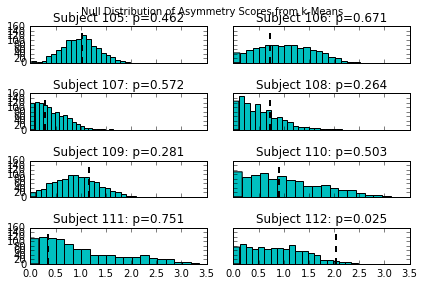

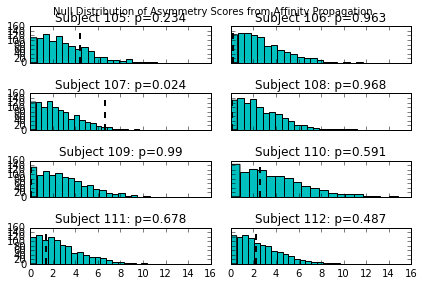

In [24]:
print('Permutation Tests Preserving Autocorrelation:')
plot_hists(k_asymmetry_shuff, scores['k_asymmetry'], title_string='Null Distribution of Asymmetry Scores from k-Means')
plot_hists(af_asymmetry_shuff, scores['af_asymmetry'], title_string='Null Distribution of Asymmetry Scores from Affinity Propagation')

Next, we perform the more lenient shuffling procedure, totally scrambling the time series of clusters, thereby destroying autocorrelation in the data.

In [25]:
#make n_subj key in each dict, the value of which is an array n_shuffles long
for i in range(n_subj):
    af_asymmetry_shuff[i] = np.zeros(n_shuffles)
    k_asymmetry_shuff[i] = np.zeros(n_shuffles)
    af_stability_shuff[i] = np.zeros(n_shuffles)
    k_stability_shuff[i] = np.zeros(n_shuffles)

#scramble the ORDER of each cluster, within each subject, thereby DESTROYING AUTOCORRELATION
for i in range(n_shuffles):
    af_clust_shuff = [0] * len(raw_clusters['labels'])
    k_clust_shuff = [0] * len(raw_k_labels)
    for j in range(n_subj):
        
        #get one subject's time series, or ts
        af_ts = raw_clusters['labels'][j*n_TR_subj:(j+1)*n_TR_subj]
        np.random.shuffle(af_ts)
        
        k_ts = raw_k_labels[j*n_TR_subj:(j+1)*n_TR_subj]
        np.random.shuffle(k_ts)
        
        af_clust_shuff[j*n_TR_subj:(j+1)*n_TR_subj] = af_ts
        k_clust_shuff[j*n_TR_subj:(j+1)*n_TR_subj] = k_ts
    
    af_trans_shuff = calculate_transition_matrices(af_clust_shuff, plot=False)
    k_trans_shuff = calculate_transition_matrices(k_clust_shuff, plot=False)
    
    for j in range(n_subj):
        af_asymmetry_shuff[j][i] = compute_asymmetry(af_trans_shuff[:,:,j])
        k_asymmetry_shuff[j][i] = compute_asymmetry(k_trans_shuff[:,:,j])
        af_stability_shuff[j][i] = compute_stability(af_trans_shuff[:,:,j])
        k_stability_shuff[j][i] = compute_stability(k_trans_shuff[:,:,j])

Permutation Tests Destroying Autocorrelation:


/nexsan/apps/hpc/Langs/Python/3.5-anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


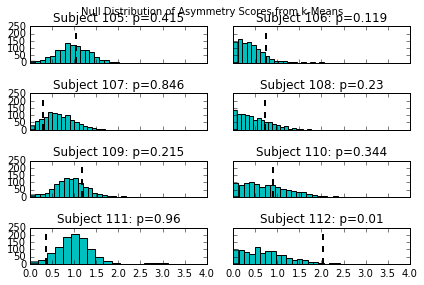

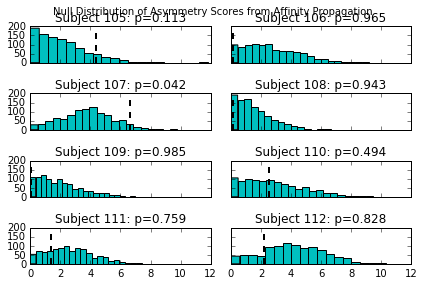

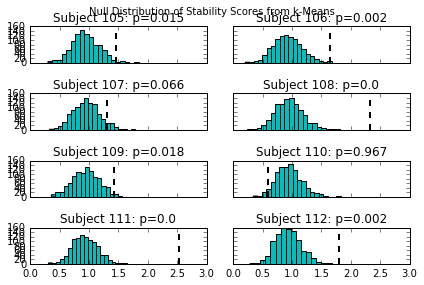

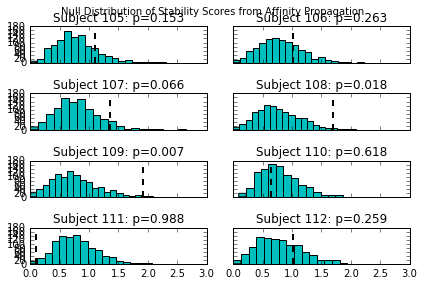

In [26]:
print('Permutation Tests Destroying Autocorrelation:')
plot_hists(k_asymmetry_shuff, scores['k_asymmetry'], title_string='Null Distribution of Asymmetry Scores from k-Means')
plot_hists(af_asymmetry_shuff, scores['af_asymmetry'], title_string='Null Distribution of Asymmetry Scores from Affinity Propagation')
plot_hists(k_stability_shuff, scores['k_stability'], title_string='Null Distribution of Stability Scores from k-Means')
plot_hists(af_stability_shuff, scores['af_stability'], title_string='Null Distribution of Stability Scores from Affinity Propagation')

# Conclusions

Individuals show a high degree of overlap in the types of BOLD activation patterns they exhibit, even at rest with no driving stimulus. However, this common vocabulatry of activity states quickly diversifies in at least two independent ways.

First, the Transition Probability Matrix of each subject is not only quantitatively but also qualitatively different from that of every other subject. More specifically, not only are the particular transition probabilities between states different for each subject, but the overall pattern that these TPMs represent also markedly differ. For instance, some subjects show _more_ asymmetry (Subject 112) or stability (Subject 108) than chance, while others show _less_ asymmetry (Subject 109) or stability (Subject 110) than chance. It would be fascinating to test whether these TPMs, or even these summary statistics, predict interesting psychological variables such as fluid intelligence. Unfortunately, I do not have access to such data at present. One caveat of these findings is that the trends uncovered by affinity propagation and k-means clustering often diverged, meaning that the clustering procedure itself was prone to noise or errors.

Second, these common activity states mask large and persistent differences in functional connectivity. Such differences were manifest in both the raw voxels as well as independently-specified anatomical parcels. Because these clusters were calculated over windows that were 10 TRs in length, whereas BOLD data could be clustered in each TR, one likely explanation for these differences in functional connectivity is differences in the TPM that produced them. Future work should seek to relate TPMs calculated over BOLD data (which have common states across subejcts) to functional connectivity data (which do not share states across subjects).